In [1]:
import os, pathlib, time, copy, gc

import torch
import torchaudio
import torch.nn as nn
import torchaudio.transforms as T
from torch import autocast
from torch.cuda.amp import GradScaler
from torchmetrics.text.wer import WordErrorRate
from models.ConformerCls4 import ConformerCls
from models.GreedyCTCDecoder import GreedyCTCDecoder

import matplotlib.pyplot as plt
import wandb

from rich_logger import RichTablePrinter
from tqdm import trange
from rich import pretty
from rich.console import Console
from IPython.display import Audio
from utils.audio_dataloader import MiniSpeechCommands
from utils.transformer_lrscheduler import TransformerLrScheduler
from utils.TextTransform import TextTransform
from utils.AvgMeter import AvgMeter

console = Console()
pretty.install()
plt.ion()
tt = TextTransform()

use_gpu = torch.cuda.is_available()
if use_gpu:
    device = 'cuda'
    print("Using CUDA")
else:
    device = 'cpu'
    print('Using CPU')

2023-06-07 06:28:54.420293: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-07 06:28:54.445764: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 06:28:54.772741: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using CUDA


In [2]:
wandb.init(
    project="Conformer-SpeechRecognition",
    config={
        "dropout": .1,
        "attention_heads": 4,
        "input_dim": 80,
        "model_dim": 144,
        "ffn_expansion_factor": 4,
        "depthwise_conv_kernel_size": 31,
        "num_conformer_layers": 16,
        "num_lstm_layers": 1,
        "num_lstm_hidden": 320,
        "num_classes": 29,
        
        "mixed_precision": False,
        "epochs": 100,
        "batch_size": 512,
        "lr": 5e-4,
        "betas": (.9, .98),
        "eps": 1e-09,
        "weight_decay": 1e-6,
        "warmup_steps": 10000,
    }
) # eps = 1e-05 if use amp if not use 1e-09
config = wandb.config

wandb: Currently logged in as: enemyr. Use `wandb login --relogin` to force relogin


In [3]:
def plot_waveform(waveform, sample_rate, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

    
def visualize_file(file: str):
    metadata = torchaudio.info(file)
    wav, sr = torchaudio.load(file)
    console.log(metadata)
    console.log(wav, wav.shape)
    title = '/'.join(file.split('/')[-2:])
    plot_waveform(wav, sr, title)
    plot_specgram(wav, sr, title)

[08:15:30] AudioMetaData(sample_rate=16000, num_frames=16000, num_channels=1, bits_per_sample=16,  ]8;id=66471;file:///tmp/ipykernel_826495/1836796892.py\1836796892.py]8;;\:]8;id=223259;file:///tmp/ipykernel_826495/1836796892.py#46\46]8;;\
           encoding=PCM_S)                                                                                         

           tensor([[0.0004, 0.0016, 0.0002,  ..., 0.0029, 0.0029, 0.0017]])                        ]8;id=183196;file:///tmp/ipykernel_826495/1836796892.py\1836796892.py]8;;\:]8;id=64436;file:///tmp/ipykernel_826495/1836796892.py#47\47]8;;\
           torch.Size([1, 16000])                                                                                  

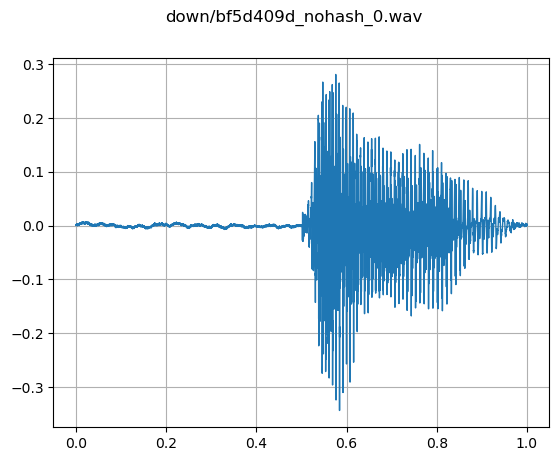

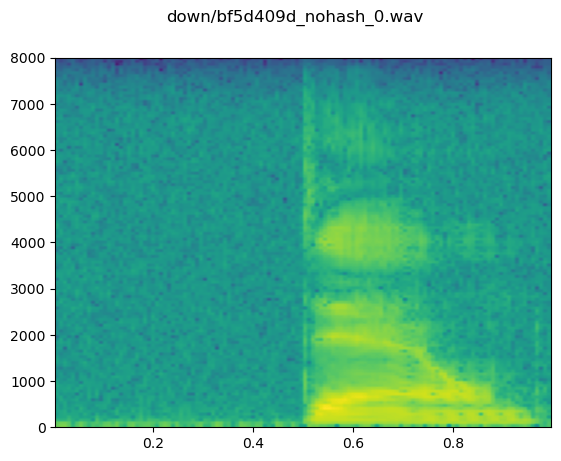

In [4]:
test_file = './datasets/speech-handsign_commands/speech/val/down/bf5d409d_nohash_0.wav'
visualize_file(test_file)
wav, sr = torchaudio.load(test_file)
Audio(wav.numpy()[0], rate=sr)

In [4]:
data_dir = './datasets/speech-handsign_commands/speech'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

def collate_fn(batch):
    spectrograms = []
    labels = []
    input_lengths = []
    label_texts = []
    label_lengths = []
    for spec, label in batch:
        spectrograms.append(spec)
        labels.append(label)
        input_lengths.append(((spec.shape[0] - 1) // 2 - 1) // 2)
        label_texts.append(tt.int_to_text(label.tolist()))
        label_lengths.append(len(label))
    input_lengths = torch.tensor(input_lengths)
    label_lengths = torch.tensor(label_lengths)
    spectrograms = torch.nn.utils.rnn.pad_sequence(spectrograms, batch_first=True)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)
    return spectrograms, input_lengths, labels, label_lengths, label_texts

time_masks = [T.TimeMasking(time_mask_param=15, p=.05) for _ in range(10)]
data_transform = {
    TRAIN: torch.nn.Sequential(
        T.MelSpectrogram(sample_rate=16000, n_mels=80, hop_length=160),#80 filter banks, 25ms window size, 10ms hop
        T.FrequencyMasking(freq_mask_param=27),
        *time_masks
    ),
    VAL: T.MelSpectrogram(sample_rate=16000, n_mels=80, hop_length=160),
    TEST: T.MelSpectrogram(sample_rate=16000, n_mels=80, hop_length=160)
}

speech_datasets = {
    x: MiniSpeechCommands(os.path.join(data_dir, x), transform=data_transform[x], text_transform=True)
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(speech_datasets[x], batch_size=config.batch_size, shuffle=True, num_workers=14, collate_fn=collate_fn)  #os.cpu_count() = 24
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = { x: len(speech_datasets[x]) for x in [TRAIN, VAL, TEST] }
class_names = speech_datasets[TRAIN].classes

for x in [TRAIN, VAL, TEST]:
    console.log("Loaded {} audios under {}".format(dataset_sizes[x], x))
console.log("Classes: ", class_names)

[06:29:18] Loaded 5760 audios under train                                                           ]8;id=106569;file:///tmp/ipykernel_3896877/751360586.py\751360586.py]8;;\:]8;id=609759;file:///tmp/ipykernel_3896877/751360586.py#49\49]8;;\

           Loaded 640 audios under val                                                              ]8;id=803090;file:///tmp/ipykernel_3896877/751360586.py\751360586.py]8;;\:]8;id=611990;file:///tmp/ipykernel_3896877/751360586.py#49\49]8;;\

           Loaded 1600 audios under test                                                            ]8;id=895313;file:///tmp/ipykernel_3896877/751360586.py\751360586.py]8;;\:]8;id=859139;file:///tmp/ipykernel_3896877/751360586.py#49\49]8;;\

           Classes:                                                                                 ]8;id=525310;file:///tmp/ipykernel_3896877/751360586.py\751360586.py]8;;\:]8;id=85653;file:///tmp/ipykernel_3896877/751360586.py#50\50]8;;\
           ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']                                              

[04:20:47] torch.Size([512, 101, 80])                                                                ]8;id=112902;file:///tmp/ipykernel_3576670/126025199.py\126025199.py]8;;\:]8;id=614010;file:///tmp/ipykernel_3576670/126025199.py#2\2]8;;\
           torch.Size([512, 5])                                                                                    

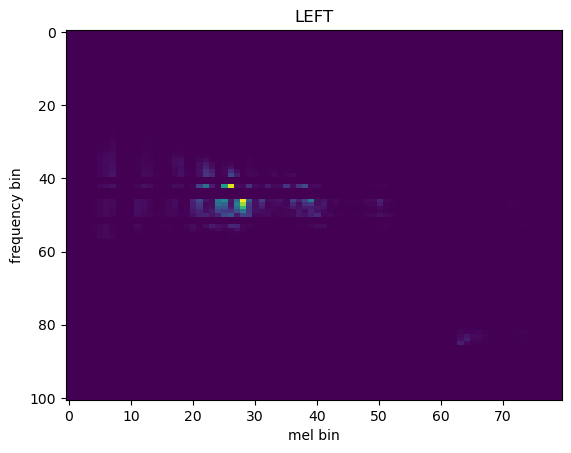

In [32]:
inputs, input_lengths, classes, label_lengths, labels_texts = next(iter(dataloaders[TRAIN]))
console.log(inputs.shape, classes.shape)
plot_fbank(inputs[0], labels_texts[0])

In [6]:
console.log(labels_texts[0], classes[0], label_lengths[0])

[03:16:47] NO tensor([13, 14,  0,  0,  0]) tensor(2)                                                ]8;id=978807;file:///tmp/ipykernel_3492028/1196201309.py\1196201309.py]8;;\:]8;id=166779;file:///tmp/ipykernel_3492028/1196201309.py#1\1]8;;\

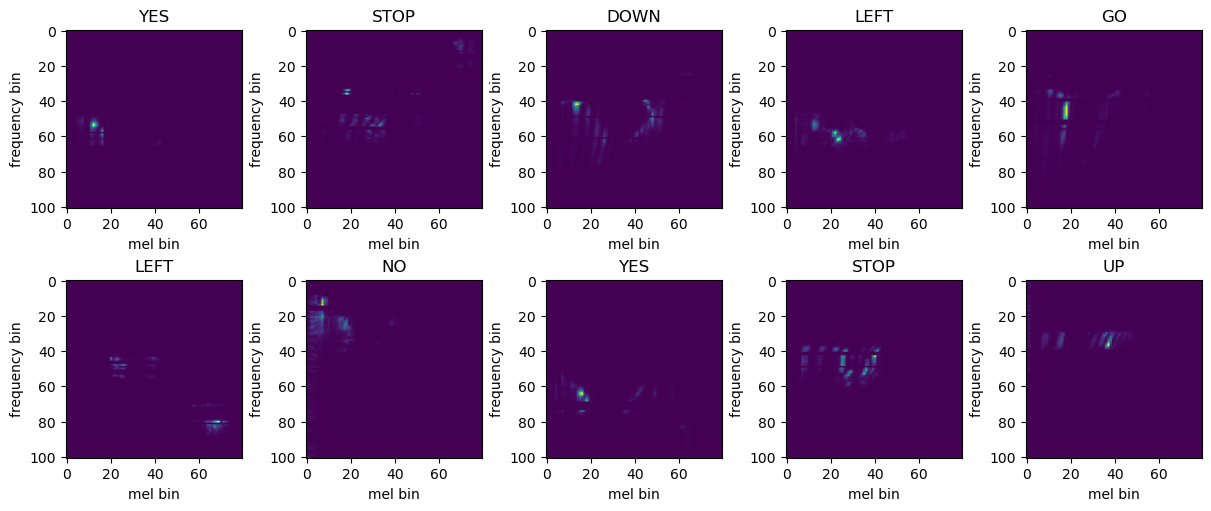

In [7]:
def visualize_batch(inps, titles=None):
    rows = 2
    cols = 5
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 5), constrained_layout=True)
    for idx, ax in enumerate(axs.ravel()):
        ax.set_title(titles[idx] or "Filter bank")
        ax.set_xlabel("mel bin")
        ax.set_ylabel("frequency bin")
        ax.imshow(inps[idx], aspect="auto")
    plt.show(block=False)
# Get a batch of training data
inputs, input_lengths, classes, label_lengths, labels_texts = next(iter(dataloaders[TRAIN]))
visualize_batch(inputs[::13], labels_texts[::13])

In [5]:
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct/len(y_pred)
    return acc


def train(model, criterion, optimizer, scheduler, scaler, dataloader, char_decoder, wer):
    model.train()
    losses = AvgMeter()
    error_rates = AvgMeter()
    for i, batch in enumerate(dataloader):
        gc.collect()
        optimizer.zero_grad()
        inputs, input_lengths, labels, label_lengths, label_texts = batch
        inputs = inputs.to(device)
        input_lengths = input_lengths.to(device)
        label_lengths = label_lengths.to(device)
        labels = labels.to(device).float()
        with autocast(enabled=config.mixed_precision, device_type=device):
            logit_outputs = model(inputs, input_lengths)
            pred_labels = torch.nn.functional.log_softmax(logit_outputs, dim=-1).transpose(0, 1).float()
            loss = criterion(pred_labels, labels, input_lengths, label_lengths)
            # loss.requires_grad = True
            pred_label_texts = char_decoder(pred_labels.detach().cpu().transpose(1, 0))
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        losses.update(loss.detach().item())
        error_rates.update(wer(pred_label_texts, label_texts))
        scheduler.step()
    if use_gpu:
        torch.cuda.empty_cache()
    return {
        "train/loss": losses.avg,
        "train/wer": error_rates.avg
    }

def validate(model, criterion, dataloader, char_decoder, wer):
    model.eval()
    losses = AvgMeter() 
    error_rates = AvgMeter()
    for i, batch in enumerate(dataloader):
        gc.collect()
        inputs, input_lengths, labels, label_lengths, label_texts = batch
        inputs = inputs.to(device)
        input_lengths = input_lengths.to(device)
        label_lengths = label_lengths.to(device)
        labels = labels.to(device).float()
        with torch.inference_mode():
            with autocast(enabled=config.mixed_precision, device_type=device):
                logit_outputs = model(inputs, input_lengths)
                pred_labels = torch.nn.functional.log_softmax(logit_outputs, dim=-1).transpose(0, 1).float()
                loss = criterion(pred_labels, labels, input_lengths, label_lengths)
                pred_label_texts = char_decoder(pred_labels.detach().cpu().transpose(1, 0))
                losses.update(loss.detach().item())
                error_rates.update(wer(pred_label_texts, label_texts))
    if use_gpu:
        torch.cuda.empty_cache()
    return {
        "val/loss": losses.avg,
        "val/wer": error_rates.avg
    }

def evaluation(model, criterion, dataloader, char_decoder, wer):
    model.eval()
    losses = AvgMeter()
    error_rates = AvgMeter()
    for i, batch in enumerate(dataloader):
        gc.collect()
        inputs, input_lengths, labels, label_lengths, label_texts = batch
        inputs = inputs.to(device)
        input_lengths = input_lengths.to(device)
        label_lengths = label_lengths.to(device)
        labels = labels.to(device).float()
        with torch.inference_mode():
            with autocast(enabled=config.mixed_precision, device_type=device):
                logit_outputs = model(inputs, input_lengths)
                pred_labels = torch.nn.functional.log_softmax(logit_outputs, dim=-1).transpose(0, 1).float()
                loss = criterion(pred_labels, labels, input_lengths, label_lengths)
                pred_label_texts = char_decoder(pred_labels.detach().cpu().transpose(1, 0))
                losses.update(loss.detach().item())
                error_rates.update(wer(pred_label_texts, label_texts))
    if use_gpu:
        torch.cuda.empty_cache()
    return {
        "eval/loss": losses.avg,
        "eval/wer": error_rates.avg
    }

In [6]:
def run_optimization_loop():
    logger_fields = {
        "epoch": {},
        "tr/loss": {
            "goal": "lower_is_better",
            "format": "{:.6f}",
            "name": r"train/loss",
        },
        "va/loss": {
            "goal": "lower_is_better",
            "format": "{:.6f}",
            "name": r"val/loss",
        },
        "tr/wer": {
            "goal": "lower_is_better",
            "format": "{:.6f}",
            "name": r"train/wer",
        },
        "va/wer": {
            "goal": "lower_is_better",
            "format": "{:.6f}",
            "name": r"val/wer",
        },
        "duration": {"format": "{:.1f}", "name": "dur(s)"},
        ".*": True,  # Any other field must be logged at the end
    }
    printer = RichTablePrinter(key="epoch", fields=logger_fields)
    printer.hijack_tqdm()
    
    conformer_classifier = ConformerCls(
        d_input = config.input_dim,
        d_model = config.model_dim,
        dropout = config.dropout,
        num_heads = config.attention_heads,
        ffn_expansion_factor = config.ffn_expansion_factor,
        depthwise_conv_kernel_size = config.depthwise_conv_kernel_size,
        num_conformer_layers = config.num_conformer_layers,
        num_lstm_layers = config.num_lstm_layers,
        num_lstm_hidden = config.num_lstm_hidden,
        num_classes = config.num_classes
    ).to(device)
    char_decoder = GreedyCTCDecoder().to(device).eval()
    criterion = nn.CTCLoss(blank=28, zero_infinity=True).to(device)
    optimizer = torch.optim.AdamW(conformer_classifier.parameters(), lr=config.lr, betas=config.betas, eps=config.eps, weight_decay=config.weight_decay)
    scheduler = TransformerLrScheduler(optimizer, config.model_dim, config.warmup_steps)
    scaler = GradScaler(enabled=config.mixed_precision)
    wer = WordErrorRate()
    gc.collect()
    if use_gpu:
        torch.cuda.set_device(0)

    start_t = time.time()
    for epoch in trange(config.epochs):
        wandb.watch(conformer_classifier, criterion, log_freq=1000)
        if use_gpu:
            torch.cuda.empty_cache()
        t = time.time()
        train_metrics = train(conformer_classifier, criterion, optimizer, scheduler, scaler, dataloaders[TRAIN], char_decoder, wer)
        printer.log(
            {
                "epoch": epoch,
                "tr/loss": train_metrics['train/loss'],
                "tr/wer": train_metrics['train/wer'],
            }
        )
        val_metrics = validate(conformer_classifier, criterion, dataloaders[VAL], char_decoder, wer)
        printer.log(
            {
                "epoch": epoch,
                "va/loss": val_metrics['val/loss'],
                "va/wer": val_metrics['val/wer'],
                "duration": time.time() - t,
            }
        )
        wandb.log(
            {
                "epoch": epoch,
                **train_metrics,
                **val_metrics
            }
        )
    printer.finalize()
    elapsed_time = time.time() - start_t
    console.log("Total Time Used : {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    start_e = time.time()
    eval_metrics = evaluation(conformer_classifier, criterion, dataloaders[TEST], char_decoder, wer)
    elapsed_time = time.time() - start_e
    console.log("Average loss on Test set : {:.6f}".format(eval_metrics['eval/loss']))
    console.log("Average wer on Test set : {:.6f}".format(eval_metrics['eval/wer']))
    console.log("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    wandb.summary['test_loss'] = eval_metrics['eval/loss']
    wandb.summary['test_wer'] = eval_metrics['eval/wer']
    wandb.finish()
    return conformer_classifier

In [7]:
model = run_optimization_loop()

┏━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓
┃ epoch ┃ train/loss ┃ val/loss  ┃ train/wer ┃ val/wer  ┃ dur(s) ┃
┡━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩
│ 0     │ 19.859930  │ 18.851313 │ 1.024089  │ 1.000000 │ 5.0    │
│ 1     │ 18.812578  │ 17.682852 │ 1.000000  │ 1.000000 │ 4.7    │
│ 2     │ 17.483353  │ 16.398604 │ 1.000000  │ 1.000000 │ 4.5    │
│ 3     │ 15.764325  │ 14.582039 │ 1.000000  │ 1.000000 │ 4.5    │
│ 4     │ 13.631283  │ 12.252528 │ 1.000000  │ 1.000000 │ 4.4    │
│ 5     │ 10.956290  │ 9.345795  │ 1.000000  │ 1.000000 │ 4.4    │
│ 6     │ 7.962185   │ 6.372678  │ 1.000000  │ 1.000000 │ 4.5    │
│ 7     │ 5.463868   │ 4.601365  │ 1.000000  │ 1.000000 │ 4.4    │
│ 8     │ 4.134414   │ 3.811891  │ 1.000000  │ 1.000000 │ 4.5    │
│ 9     │ 3.692210   │ 3.603062  │ 1.000000  │ 1.000000 │ 4.5    │
│ 10    │ 3.553320   │ 3.518571  │ 1.000000  │ 1.000000 │ 4.6    │
│ 11    │ 3.478203   │ 3.448804  │ 1.000000  │ 1.000000 │ 4.4    │
│ 12    │ 3.409617   │ 3.392838  │ 1.000000  │ 1.000000 │ 4.7    │
│ 13    │ 3.348545   │ 3.295410  │ 1.000000  │ 1.000000 │ 4.6    │
│ 14    │ 3.293396   │ 3.259733  │ 1.000000  │ 1.000000 │ 4.7    │
│ 15    │ 3.236475   │ 3.196243  │ 1.000000  │ 1.000000 │ 4.6    │
│ 16    │ 3.182701   │ 3.150714  │ 1.000000  │ 1.000000 │ 4.7    │
│ 17    │ 3.131790   │ 3.094420  │ 1.000000  │ 1.000000 │ 4.6    │
│ 18    │ 3.074399   │ 3.146298  │ 1.000000  │ 1.000000 │ 4.5    │
│ 19    │ 3.013786   │ 2.997483  │ 1.000000  │ 1.000000 │ 4.6    │
│ 20    │ 2.937068   │ 2.894477  │ 1.000000  │ 1.000000 │ 4.8    │
│ 21    │ 2.852982   │ 2.787170  │ 1.000000  │ 1.000000 │ 5.0    │
│ 22    │ 2.753990   │ 2.681117  │ 1.000000  │ 1.000000 │ 4.8    │
│ 23    │ 2.634816   │ 2.872499  │ 0.999186  │ 0.995117 │ 4.7    │
│ 24    │ 2.497231   │ 2.481599  │ 0.998372  │ 1.000000 │ 4.7    │
│ 25    │ 2.352205   │ 2.312071  │ 0.998698  │ 0.999023 │ 4.7    │
│ 26    │ 2.199326   │ 2.143495  │ 0.998372  │ 0.999023 │ 4.7    │
│ 27    │ 2.030705   │ 1.894289  │ 0.997070  │ 1.000000 │ 4.7    │
│ 28    │ 1.864623   │ 1.952901  │ 0.998372  │ 0.993164 │ 4.7    │
│ 29    │ 1.730527   │ 1.792637  │ 0.998535  │ 1.000000 │ 4.7    │
│ 30    │ 1.553269   │ 1.662486  │ 0.998861  │ 1.000000 │ 5.3    │
│ 31    │ 1.448233   │ 1.440989  │ 0.999023  │ 0.997070 │ 5.3    │
│ 32    │ 1.319683   │ 1.543216  │ 0.995605  │ 0.999023 │ 5.1    │
│ 33    │ 1.176347   │ 1.397849  │ 0.984212  │ 0.999023 │ 4.9    │
│ 34    │ 1.072805   │ 1.255947  │ 0.990885  │ 0.995117 │ 5.0    │
│ 35    │ 0.992458   │ 0.969441  │ 0.990234  │ 0.985352 │ 4.8    │
│ 36    │ 0.910489   │ 0.976825  │ 0.990723  │ 0.984375 │ 4.8    │
│ 37    │ 0.879098   │ 0.867500  │ 0.989583  │ 0.995117 │ 4.9    │
│ 38    │ 0.783389   │ 0.801339  │ 0.992188  │ 0.992188 │ 5.1    │
│ 39    │ 0.709348   │ 0.747427  │ 0.988607  │ 0.991211 │ 4.9    │
│ 40    │ 0.647386   │ 0.839550  │ 0.986816  │ 0.983398 │ 4.8    │
│ 41    │ 0.617901   │ 0.746207  │ 0.978027  │ 0.984375 │ 5.1    │
│ 42    │ 0.592873   │ 0.659939  │ 0.974772  │ 0.987305 │ 4.9    │
│ 43    │ 0.560567   │ 0.621517  │ 0.967773  │ 0.963867 │ 4.9    │
│ 44    │ 0.539903   │ 0.830863  │ 0.950846  │ 0.957031 │ 5.0    │
│ 45    │ 0.522953   │ 0.620527  │ 0.968587  │ 0.953125 │ 5.1    │
│ 46    │ 0.480616   │ 0.667983  │ 0.957845  │ 0.944336 │ 5.0    │
│ 47    │ 0.454233   │ 0.483506  │ 0.962891  │ 0.973633 │ 5.0    │
│ 48    │ 0.445071   │ 0.510914  │ 0.971680  │ 0.961914 │ 5.1    │
│ 49    │ 0.398843   │ 0.683073  │ 0.969564  │ 0.973633 │ 5.0    │
│ 50    │ 0.413227   │ 0.356510  │ 0.963704  │ 0.973633 │ 5.2    │
│ 51    │ 0.336907   │ 0.811029  │ 0.974935  │ 0.989258 │ 5.3    │
│ 52    │ 0.358203   │ 0.524313  │ 0.970378  │ 0.981445 │ 5.4    │
│ 53    │ 0.367262   │ 0.569574  │ 0.972005  │ 0.958008 │ 5.3    │
│ 54    │ 0.374427   │ 0.354324  │ 0.965983  │ 0.982422 │ 5.1    │
│ 55    │ 0.338436   │ 0.433944  │ 0.973633  │ 0.984375 │ 5.1    │
│ 56    │ 0.341401   │ 0.506968  │ 0.976237  │ 

wandb: ERROR Summary data exceeds maximum size of 10.4MB. Dropping it.


[06:38:22] Total Time Used : 8m 49s                                                                ]8;id=939712;file:///tmp/ipykernel_3896877/2869838884.py\2869838884.py]8;;\:]8;id=101253;file:///tmp/ipykernel_3896877/2869838884.py#84\84]8;;\

[06:38:24] Average loss on Test set : 0.363925                                                     ]8;id=412140;file:///tmp/ipykernel_3896877/2869838884.py\2869838884.py]8;;\:]8;id=40946;file:///tmp/ipykernel_3896877/2869838884.py#88\88]8;;\

           Average wer on Test set : 0.941895                                                      ]8;id=576901;file:///tmp/ipykernel_3896877/2869838884.py\2869838884.py]8;;\:]8;id=104913;file:///tmp/ipykernel_3896877/2869838884.py#89\89]8;;\

           Evaluation completed in 0m 2s                                                           ]8;id=210633;file:///tmp/ipykernel_3896877/2869838884.py\2869838884.py]8;;\:]8;id=786198;file:///tmp/ipykernel_3896877/2869838884.py#90\90]8;;\

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss,█▇▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/wer,█▆▆▆▆▆▆▆▆▆▆▆▆▅▆▆▅▄▄▄▄▄▅▅▄▄▄▃▄▃▄▄▃▄▂▁▃▄▃▂
val/loss,█▇▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/wer,██████████████▇▇▇▅▅▅▆▅▇▆▆█▆▆▇▃▁▇▄▆▇▅▆▆▄▃
epoch,99
test_loss,0.36393
test_wer,0.94189
train/loss,0.2027
train/wer,0.9305
val/loss,0.37492


In [8]:
console.log(model)

[06:06:52] ConformerCls(                                                                             ]8;id=257510;file:///tmp/ipykernel_3728679/977660610.py\977660610.py]8;;\:]8;id=287352;file:///tmp/ipykernel_3728679/977660610.py#1\1]8;;\
             (conv_subsample): ConvolutionSubsampling(                                                             
               (conv_subsample): Sequential(                                                                       
                 (0): Conv2d(1, 144, kernel_size=(3, 3), stride=(2, 2))                                            
                 (1): ReLU()                                                                                       
                 (2): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2))                                          
                 (3): ReLU()                                                                                       
               )                                                                                                   
             )                                                                                                     
             (linear_proj): Linear(in_features=2736, out_features=144, bias=True)                                  
             (dropout): Dropout(p=0.1, inplace=False)                                                              
             (conformer_block): Conformer(                                                                         
               (conformer_layers): ModuleList(                                                                     
                 (0-15): 16 x ConformerLayer(                                                                      
                   (ffn1): _FeedForwardModule(                                                                     
                     (sequential): Sequential(                                                                     
                       (0): LayerNorm((144,), eps=1e-05, elementwise_affine=True)                                  
                       (1): Linear(in_features=144, out_features=576, bias=True)                                   
                       (2): SiLU()                                                                                 
                       (3): Dropout(p=0.0, inplace=False)                                                          
                       (4): Linear(in_features=576, out_features=144, bias=True)                                   
                       (5): Dropout(p=0.0, inplace=False)                                                          
                     )                                                                                             
                   )                                                                                               
                   (self_attn_layer_norm): LayerNorm((144,), eps=1e-05, elementwise_affine=True)                   
                   (self_attn): MultiheadAttention(                                                                
                     (out_proj): NonDynamicallyQuantizableLinear(in_features=144, out_features=144,                
           bias=True)                                                                                              
                   )                                                                                               
                   (self_attn_dropout): Dropout(p=0.0, inplace=False)                                              
                   (conv_module): _ConvolutionModule(                                                              
                     (layer_norm): LayerNorm((144,), eps=1e-05, elementwise_affine=True)                           
                     (sequential): Sequential(                                                                     
                       (0): Conv1d(144, 

In [8]:
torch.save(model.state_dict(), './weights/conformer_classifier_bn_4layers.pt')

In [10]:
char_decoder = GreedyCTCDecoder().to(device).eval()
test_file = 'datasets/speech-handsign_commands/speech/val/stop/bfdb9801_nohash_0.wav'
wav, sr = torchaudio.load(test_file)
spec = data_transform[TEST](wav)
spec = spec.transpose(1, 2)
input_length = torch.tensor([((spec.shape[1] - 1) // 2 - 1) // 2])
logit = model(spec.to(device), input_length.to(device))
pred = torch.nn.functional.log_softmax(logit, dim=-1).transpose(0, 1).float()
pred_label_text = char_decoder(pred.detach().cpu().transpose(1, 0))
console.log(pred_label_text)
Audio(wav.numpy()[0], rate=sr)

[06:07:04] ['STOP']                                                                                 ]8;id=691487;file:///tmp/ipykernel_3728679/163590701.py\163590701.py]8;;\:]8;id=695095;file:///tmp/ipykernel_3728679/163590701.py#10\10]8;;\

In [48]:
torch.onnx.export(model, (inputs[0].unsqueeze(0).cuda(), input_lengths[0].unsqueeze(0).cuda()), "./weights/conformer_classifier_model.onnx")

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 1 ERROR ========================
ERROR: missing-standard-symbolic-function
Exporting the operator 'aten::unflatten' to ONNX opset version 14 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.
None
<Set verbose=True to see more details>




UnsupportedOperatorError: Exporting the operator 'aten::unflatten' to ONNX opset version 14 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.

In [51]:
model2 = ConformerCls(
        d_input = config.input_dim,
        d_model = config.model_dim,
        dropout = config.dropout,
        num_heads = config.attention_heads,
        ffn_expansion_factor = config.ffn_expansion_factor,
        depthwise_conv_kernel_size = config.depthwise_conv_kernel_size,
        num_conformer_layers = config.num_conformer_layers,
        num_lstm_layers = config.num_lstm_layers,
        num_lstm_hidden = config.num_lstm_hidden,
        num_classes = config.num_classes
    )
model2.load_state_dict(torch.load('weights/conformer_classifier_bn.pt'))

<All keys matched successfully>